In [287]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.fftpack import fft, ifft
from scipy.signal import wiener, resample
from skimage.restoration import denoise_wavelet

import os
import wfdb # MIT-BIH files
import pywt
import h5py

ARRYTHMIA_PATH = "data/arrythmia_rates/"
NORMAL_PATH = "data/normal_rates/"


anomalies = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

normal = ['N'] 


**N** - NORMAL, Normal beat <br>
**L** - LBBB, Left bundle branch block beat <br>
**R** - RBBB, Right bundle branch block beat <br>
**a** - ABERR, Aberrated atrial premature beat <br>
**V** - PVC, Premature ventricular contraction <br>
**F** - FUSION, Fusion of ventricular and normal beat <br>
**J** - NPC, Nodal (junctional) premature beat <br>
**A** - APC, Atrial premature contraction <br>
**S** - SVPB, Premature or ectopic supraventricular beat <br>
**E** - VESC, Ventricular escape beat <br>
**j** - NESC, Nodal (junctional) escape beat <br>
**/** - PACE, Paced beat <br>
**f** - PFUS, Fusion of paced and normal beat <br>
**e** - AESC, Atrial escape beat <br>

In [3]:
for file in os.listdir(ARRYTHMIA_PATH)[:3]:
    print(file)
    if file.endswith("atr"):
        temp = wfdb.rdann(ARRYTHMIA_PATH + file.split(".")[0], "atr", sampto=300)
    if file.endswith("dat"):
        record = wfdb.rdrecord(ARRYTHMIA_PATH + file.split(".")[0], sampto=300)

100.atr
100.dat
100.hea


I only need **MLII (Modified Lead II)** signals, because they are the most essential here.

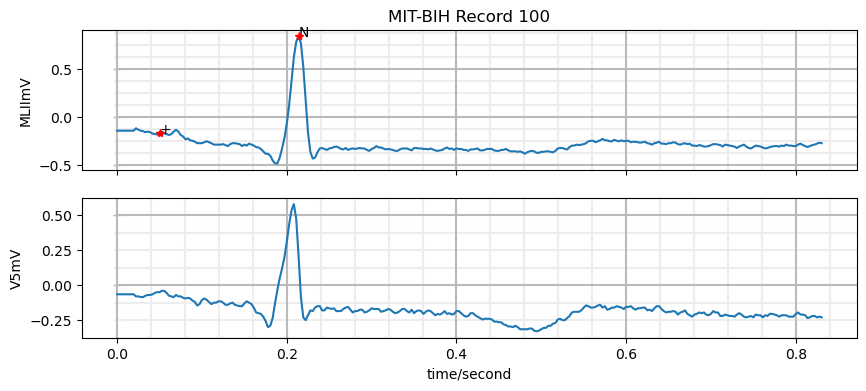

In [5]:
wfdb.plot_wfdb(record=record, annotation=temp, plot_sym=True,
                   time_units='seconds', title='MIT-BIH Record 100',
                   figsize=(10,4), ecg_grids='all')

In [6]:
record.p_signal[18]

array([-0.17, -0.05])

In [7]:
temp.sample

array([18, 77], dtype=int64)

In [151]:
def plot_signal(ax, signal: np.array, annot_sample: int, annot_symbol: str, fs=360):
    #fig = plt.figure(figsize=(10, 5))
    #ax = fig.add_subplot(111)
    ax.plot(np.arange(signal.shape[0]) / fs, signal, c="springgreen")
    ax.plot(annot_sample / fs, signal[annot_sample], 'ro', alpha=0.5)
    ax.annotate(annot_symbol, [annot_sample / fs + 0.02, signal[annot_sample]], c="white")
    ax.set_ylabel("Signal Strength [mV]")
    ax.set_xlabel("Seconds [s]")

    ax.set_facecolor((0.1, 0.1, 0.1))

    ax.set_title("MLII Signal Part")
    ax.grid()
    
    return ax


def plot_signal_data(ax, x: np.array, y: np.array, plot_kws: dict = {}, fs: int = 360):
    if "c" not in plot_kws.keys():
        plot_kws["c"] = "green"
    
    ax.plot(x, y, **plot_kws)
    ax.set_ylabel("Signal Strength [mV]")
    ax.set_xlabel("Seconds [s]")

    ax.set_facecolor((0.1, 0.1, 0.1))

    ax.set_title("MLII Signal Part")
    ax.grid()
    
    return ax

In [9]:
def load_full_ecg(path, id):
    record = wfdb.rdrecord(path + id)
    ann = wfdb.rdann(path + id, "atr")

    signal = record.p_signal[:, 0] # MLII
    ann_sample = ann.sample # annotation locations
    ann_symbol = ann.symbol # annotation symbols
    
    return signal, ann_sample, ann_symbol

In [10]:
seconds = 1.2 # window around annotation
labels = []
signals = []
symbols = []
for patient in set([file[:3] for file in os.listdir(ARRYTHMIA_PATH)]): # unique patient ids
    ecg_signal, ecg_annotation, annotation_symbol = load_full_ecg(ARRYTHMIA_PATH, patient)
    
    for smpl, symb in zip(ecg_annotation, annotation_symbol):
        if symb in anomalies: # looking only for abnormal annotations here
            temp_signal = ecg_signal[smpl-int(seconds*360):smpl+int(seconds*360)]

            if len(temp_signal) > 0:
                signals.append(temp_signal)
                labels.append(1) # marking anomalied as 1
                symbols.append(symb)

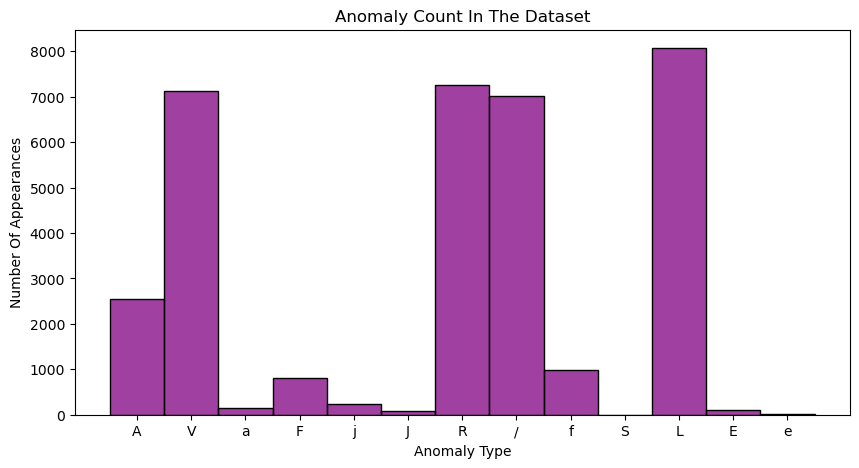

In [11]:
plt.figure(figsize=(10,5))
sns.histplot(np.array(symbols), color="purple")
plt.title("Anomaly Count In The Dataset")
plt.xlabel("Anomaly Type")
plt.ylabel("Number Of Appearances")
plt.show()

# Plotting random anomalies

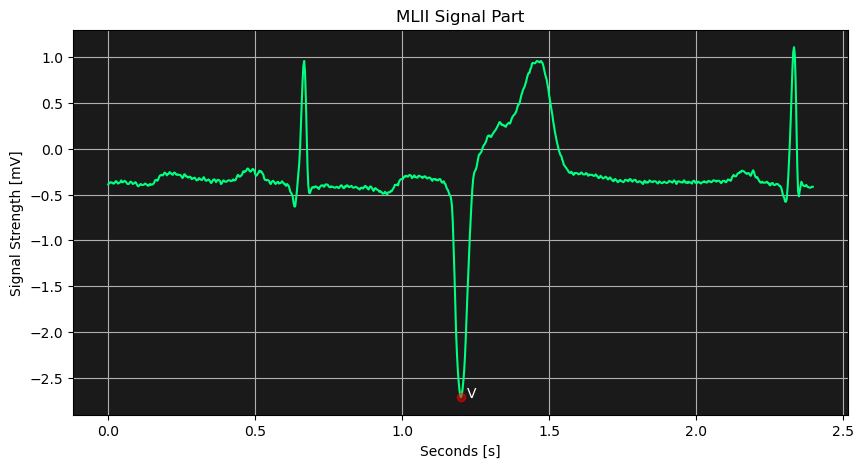

In [157]:
idx = symbols.index("V")
fig, ax = plt.subplots(figsize=(10,5))
a = plot_signal(ax, signals[idx], int(seconds*360), symbols[idx])

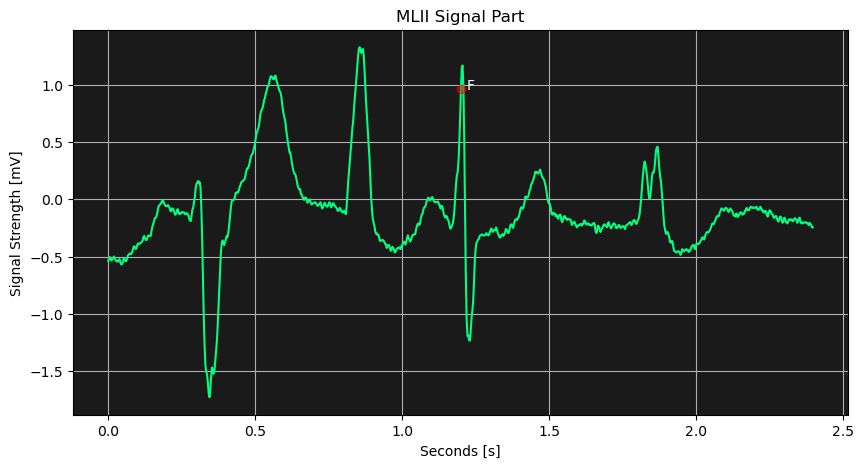

In [191]:
idx = symbols.index("F")
fig, ax = plt.subplots(figsize=(10,5))
a = plot_signal(ax, signals[idx], int(seconds*360), symbols[idx])

In [50]:
for file in os.listdir(NORMAL_PATH)[:3]:
    print(file)
    if file.endswith("atr"):
        temp = wfdb.rdann(NORMAL_PATH + file.split(".")[0], "atr")
    if file.endswith("dat"):
        record = wfdb.rdrecord(NORMAL_PATH + file.split(".")[0])

16265.atr
16265.dat
16265.hea


In [26]:
labels_tt = []
signals_tt = []
symbols_tt = []
for patient in set([file[:5] for file in os.listdir(NORMAL_PATH)]): # unique patient ids
    if not patient[0].isdigit():
        continue
    ecg_signal, ecg_annotation, annotation_symbol = load_full_ecg(NORMAL_PATH, patient)
    
    for smpl, symb in zip(ecg_annotation, annotation_symbol):
        temp_signal = ecg_signal[smpl-int(seconds*128):smpl+int(seconds*128)]
            
        signals_tt.append(temp_signal)
        labels_tt.append(0)
        symbols_tt.append(symb)

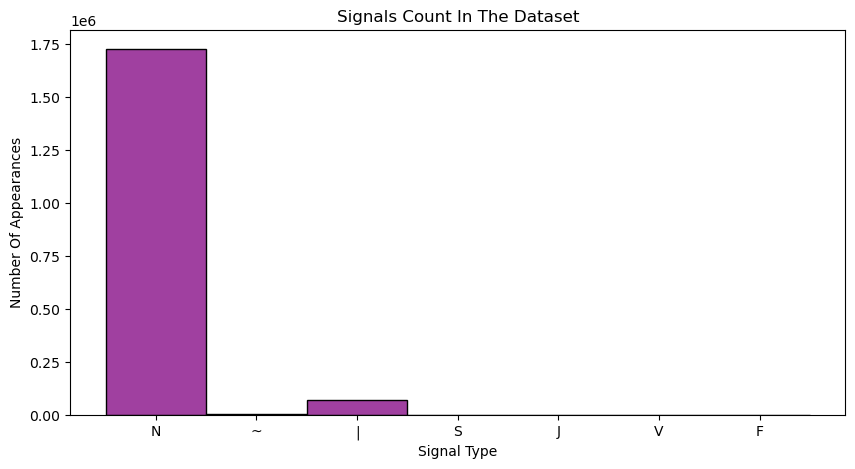

In [28]:
plt.figure(figsize=(10,5))
sns.histplot(np.array(symbols_tt), color="purple")
plt.title("Signals Count In The Dataset")
plt.xlabel("Signal Type")
plt.ylabel("Number Of Appearances")
plt.show()

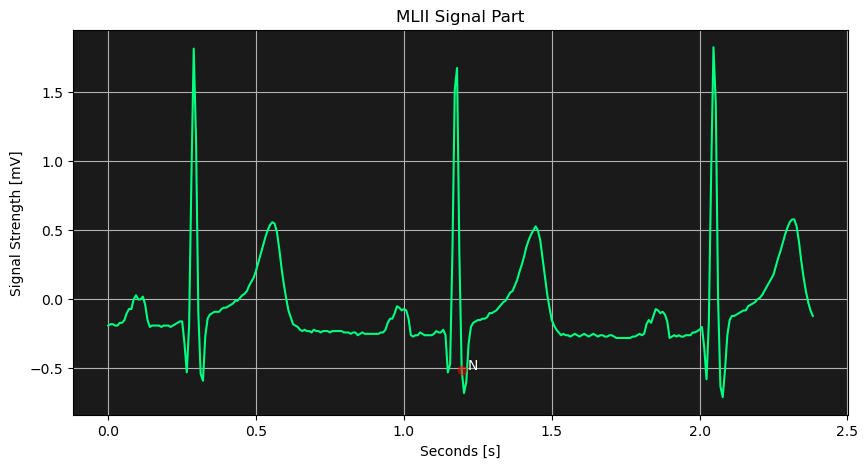

In [30]:
fig, ax = plt.subplots(figsize=(10,5))
plot_signal(ax, signals_tt[700000], int(seconds*128), symbols_tt[700000], fs=128)

plt.show()

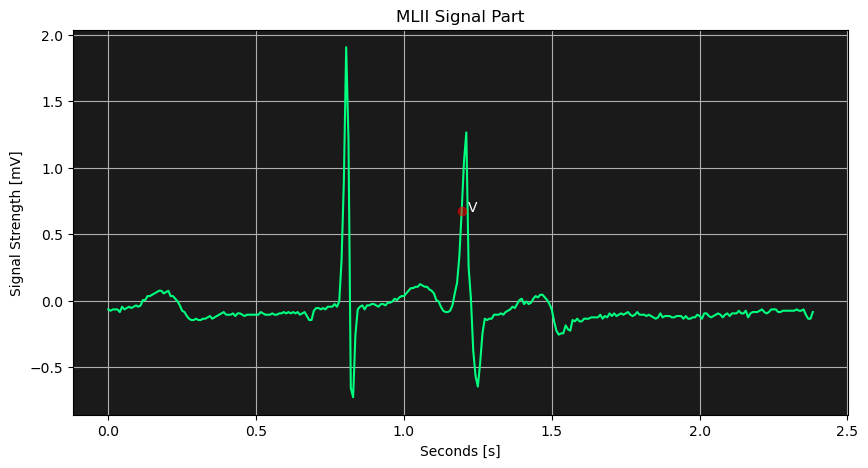

In [32]:
idx = symbols_tt.index("V")
fig, ax = plt.subplots(figsize=(10,5))
plot_signal(ax, signals_tt[idx], int(seconds*128), symbols_tt[idx], fs=128)

plt.show()

# FFT + Wiener

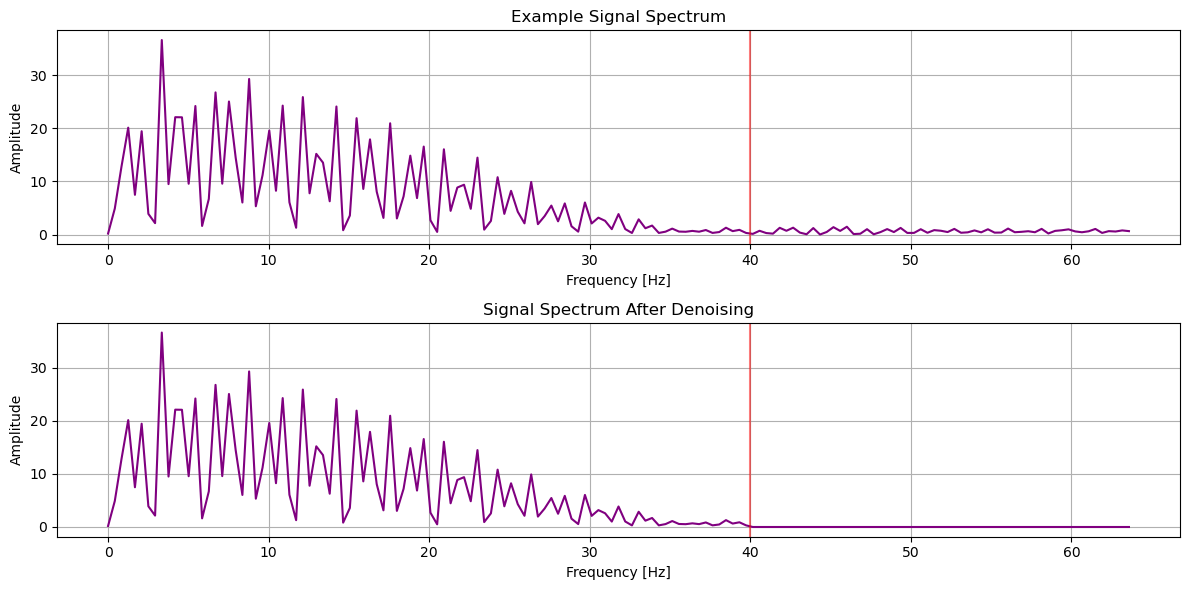

In [215]:
t_anomaly = np.linspace(0, time_frame, int(360*time_frame))
t_normal = np.linspace(0, time_frame, int(128*time_frame))[:-1]


def fft_threshold(signal: np.array, fs: int, threshold: int = 40):
    t = np.linspace(0, time_frame, int(fs*time_frame))
    if fs == 360:
        t = t[:-1]
    
    fft_signal = fft(signal)
    frequencies = np.fft.fftfreq(len(fft_signal), 1/fs)

    fft_signal_filtered = fft_signal.copy()
    fft_signal_filtered[(frequencies > 40)] = 0

    filtered_signal = ifft(fft_signal_filtered)

    return fft_signal, fft_signal_filtered, frequencies, filtered_signal.real



def fft_wiener_denoise(signal: np.array, fs: int, time_frame: float = 2*1.2, threshold=40, wiener_size=9):
    _, _, _, filtered_signal = fft_threshold(signal, fs, threshold) # fft frequency threshold

    return wiener(filtered_signal, mysize=wiener_size)


fft_signal, fft_signal_filtered, frequencies, _ = fft_threshold(signal=signals_tt[50000], fs=128)


plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_signal)[:len(frequencies)//2], c="purple")
plt.axvline(x=40, c="red", alpha=0.5)
plt.title('Example Signal Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(frequencies[:len(frequencies)//2], np.abs(fft_signal_filtered)[:len(frequencies)//2], c="purple")
plt.axvline(x=40, c="red", alpha=0.5)
plt.title('Signal Spectrum After Denoising')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.grid()

plt.show()

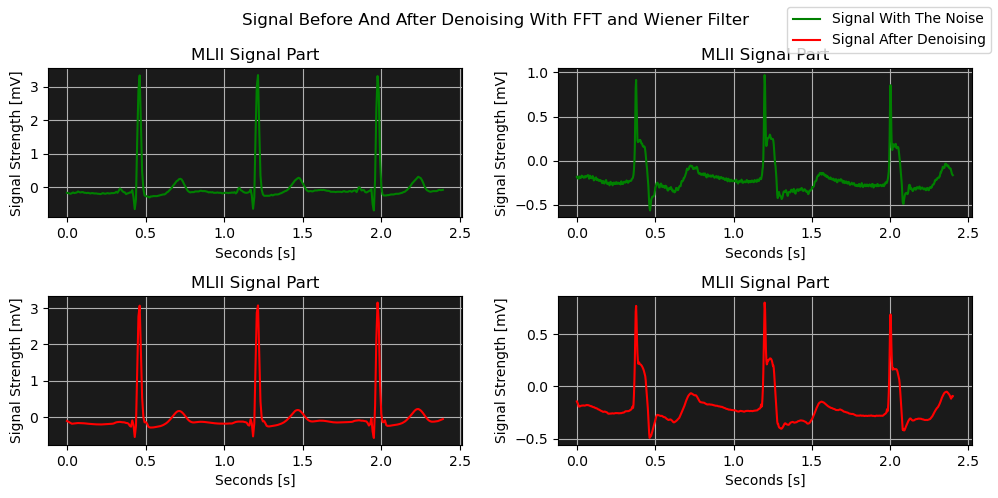

In [179]:
fig, axes = plt.subplots(figsize=(10,5), nrows=2, ncols=2)

plot_signal_data(axes[0, 0], t_normal, signals_tt[20000], plot_kws={"label": 'Signal With The Noise'}, fs=128)
plot_signal_data(axes[1, 0], t_normal, fft_wiener_denoise(signals_tt[20000], 128, time_frame), plot_kws={"label": 'Signal After Denoising', "c": "red"}, fs=128)

plot_signal_data(axes[0, 1], t_anomaly, signals[20000], fs=360)
plot_signal_data(axes[1, 1], t_anomaly, fft_wiener_denoise(signals[20000], 360, time_frame), plot_kws={"c": "red"}, fs=360)


fig.legend()
fig.suptitle('Signal Before And After Denoising With FFT and Wiener Filter')

plt.tight_layout()
plt.show()

# Wavelet filter

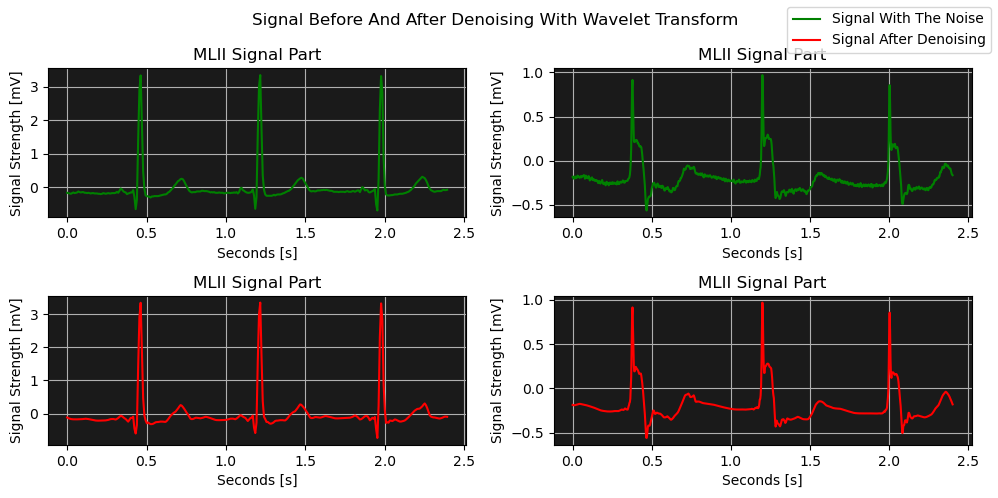

In [189]:
def mean_absolute_deviation(signal: np.array, axis=None):
    return np.mean(np.absolute(signal - np.mean(signal, axis)), axis)

def wavelet_denoising(x, wavelet='sym4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * mean_absolute_deviation(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')


fig, axes = plt.subplots(figsize=(10,5), nrows=2, ncols=2)

plot_signal_data(axes[0, 0], t_normal, signals_tt[20000], plot_kws={"label": 'Signal With The Noise'}, fs=128)
plot_signal_data(axes[1, 0], t_normal, wavelet_denoising(signals_tt[20000]), plot_kws={"label": 'Signal After Denoising', "c": "red"}, fs=128)

plot_signal_data(axes[0, 1], t_anomaly, signals[20000], fs=360)
plot_signal_data(axes[1, 1], t_anomaly, wavelet_denoising(signals[20000]), plot_kws={"c": "red"}, fs=360)


fig.legend()
fig.suptitle('Signal Before And After Denoising With Wavelet Transform')

plt.tight_layout()
plt.show()

In [167]:
def normalize_signal(signal):
    min_val = np.min(signal)
    max_val = np.max(signal)
    return (signal - min_val) / (max_val - min_val)



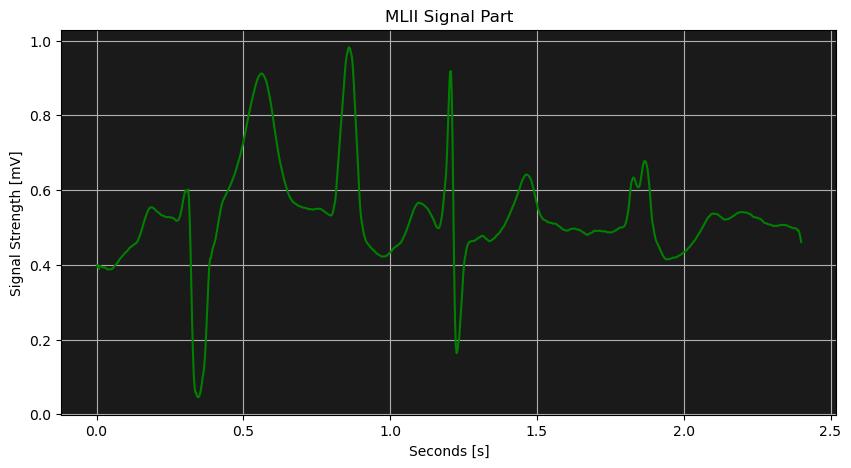

In [217]:
fig, ax = plt.subplots(figsize=(10,5))

plot_signal_data(ax, t_anomaly, fft_wiener_denoise(normalize_signal(signals[993]), fs=360))

plt.show()

# Creating a scaled and denoised dataset

In [273]:
def generate_dataset(seconds: float = 1.2):
    labels = []
    signals = []
    symbols = []
    
    # Anomalies
    for patient in set([file[:3] for file in os.listdir(ARRYTHMIA_PATH)]): # unique patient ids
        ecg_signal, ecg_annotation, annotation_symbol = load_full_ecg(ARRYTHMIA_PATH, patient)
        
        for smpl, symb in zip(ecg_annotation, annotation_symbol):
            if symb in anomalies: # looking only for abnormal annotations here
                temp_signal = ecg_signal[smpl-int(seconds*360):smpl+int(seconds*360)]  # fs = 360
    
                if temp_signal.shape[0] == 864: # 2.4s shape for fs=360
                    temp_signal = normalize_signal(temp_signal)
                    temp_signal = fft_wiener_denoise(temp_signal, fs=360)
                    
                    signals.append(temp_signal)
                    labels.append(1) # marking anomalied as 1
                    symbols.append(symb)

    anomaly_count = len(signals)
                    

    # Normal
    for patient in set([file[:5] for file in os.listdir(NORMAL_PATH)]):
        if not patient[0].isdigit():
            continue
        ecg_signal, ecg_annotation, annotation_symbol = load_full_ecg(NORMAL_PATH, patient)
        
        for smpl, symb in zip(ecg_annotation, annotation_symbol):
            temp_signal = ecg_signal[smpl-int(seconds*128):smpl+int(seconds*128)]  # fs = 128
            
            if temp_signal.shape[0] == 306: # 2.4 shape for fs=128 (in this dataset)
                temp_signal = resample(temp_signal, 864) # resampling in order to get the same dimension
                temp_signal = normalize_signal(temp_signal)
                temp_signal = fft_wiener_denoise(temp_signal, fs=128)
                
                signals.append(temp_signal)
                labels.append(0) # marking normal as 0
                symbols.append(symb)

    separate_idx = np.random.randint(0, 1500000) + anomaly_count

    X_test = np.array(signals[separate_idx:separate_idx+100000] + signals[:anomaly_count])
    y_test = np.array(labels[separate_idx:separate_idx+100000] + labels[:anomaly_count])

    X_train = np.array(signals[anomaly_count:separate_idx] + signals[separate_idx+100000:])
    y_train = np.array(labels[anomaly_count:separate_idx] + labels[separate_idx+100000:])

    return X_train, y_train, X_test, y_test
    

    

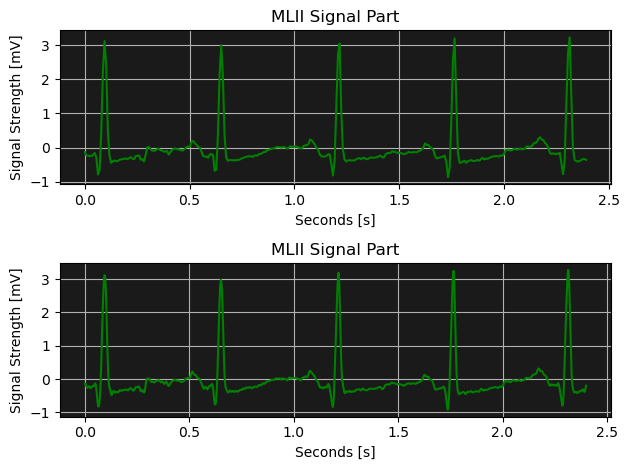

In [243]:

fig, axes = plt.subplots(nrows=2)



plot_signal_data(axes[0], t_normal, signals_tt[1000], fs=128)
plot_signal_data(axes[1], t_anomaly, resample(signals_tt[1000], 864))
plt.tight_layout()
plt.show()

In [275]:
X_train, y_train, X_test, y_test = generate_dataset()

In [299]:
random_indices = np.random.choice(X_train.shape[0], size=500000, replace=False)

In [305]:
with h5py.File("data/X_train.h5", 'w') as f:
    f.create_dataset('X_train', data=X_train[random_indices, :], compression='gzip')